In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os

In [3]:
parent_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(parent_dir)

In [4]:
from src import model
from src import utils

Hello world!


In [5]:
import numpy as np
import pandas as pd
import scipy
import datetime

In [6]:
import pymc3 as pm

In [7]:
import matplotlib.pyplot as plt

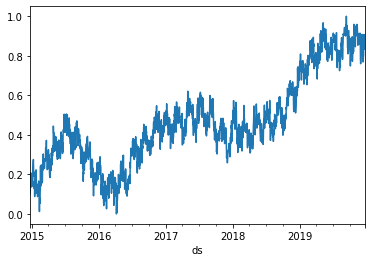

In [8]:
df = utils.random_timeseries()
df.set_index(df['ds']).drop(columns=['t', 'ds'])['y_1'].plot()

In [9]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [10]:
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

In [11]:
s = np.linspace(0, 0.8 * np.max(df['t']), 25 + 1)[1:]

# * 1 casts the boolean to integers
# A is a boolean matrix specifying which observation time stamps (vector t) --> rows
# have surpasses which changepoint time stamps (vector s) --> columns
A = (df['t'][:, None] > s) * 1

F = np.concatenate([
    fourier_series(df['t'], 365.25, 4), # Seasonality w/ yearly period
    fourier_series(df['t'], 7, 3) # Seasonality w/ weekly period
], axis = 1)

In [17]:
# Generate a PyMC3 Model context
m = pm.Model()

with m:
    
    # Priors
    k = pm.Normal('k', 0, 5)
    m = pm.Normal('m', 0, 5)
    delta = pm.Laplace('delta', 0, 0.05, shape = 25)
    beta = pm.Normal('beta', 0, 10, shape = F.shape[1])
    
    # Model
    
    # Linear trend
    gamma = -s * delta
    y = (k + det_dot(A, delta)) * df['t'] + (m + det_dot(A, gamma))
    
    # Seasonality
    y += det_dot(F, beta)
    
    # Likelihood
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', mu=y, sd=sigma, observed=df['y_1'])

In [20]:
with m:    
    trace = pm.sample(500)
    
pm.traceplot(trace)

AttributeError: __enter__

In [ ]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta = trace['beta']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['y_1'].max()

seasonality = det_seasonality_posterior(beta, F) * df['y_1'].max()

date = df['ds'].dt.to_pydatetime()
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + seasonality).mean(1), lw=0.5)
plt.scatter(date, df['y_1'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(seasonality, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, seasonality.mean(1)[sunday: sunday + 7])
quant = np.quantile(seasonality, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)